# Pre-requisite

In [4]:
import math
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


# Pre-processing

In [5]:

def frobenius_normalize(A):
    return A / A.norm(p='fro')

def spectral_normalize(A):
    u, s, v = torch.linalg.svd(A, full_matrices=False)
    return A / s[0]

def polar_normalize(A):
    U, _, Vh = torch.linalg.svd(A, full_matrices=False)
    return U @ Vh

def exp_approx(x, order=10):
    result = 0
    term = torch.eye(n=x.shape[0], device=x.device)
    result = result + term
    for i in range(1, order + 1):
        term = torch.mm(term, x) / i
        result = result + term
    return result

# Defining Symmetry Function

In [6]:
class GeneratorLatent(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        self.algebra = torch.nn.Parameter(torch.empty((num_features, num_features)))
        self.reset_parameters()
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.algebra, a=math.sqrt(5))

class GroupLatent(nn.Module):
    def __init__(self, num_features, num_generators, LOSS_MODE="MAE"):
        super().__init__()
        self.num_generators = num_generators
        self.LOSS_MODE = LOSS_MODE
        self.num_features = num_features
        self.group = nn.ModuleList([GeneratorLatent(self.num_features) for _ in range(self.num_generators)])
        self.reset_parameters()


        self.criterion_cos = nn.CosineSimilarity(dim=0)
        self.eps = 1e-5

    def reset_parameters(self):
        for generator in self.group:
            generator.reset_parameters()

    def forward(self, theta, x, order=10):
        transformed = x.clone()
        for i, generator in enumerate(self.group):
            inter = 0
            term = torch.eye(x.shape[-1], device=x.device)
            inter = inter + term.expand(x.shape[0], -1, -1)
            for k in range(1, order + 1):
                THETA = ((theta[i]) ** k)[:, None, None].expand(x.shape[0], x.shape[-1], x.shape[-1])
                term = (term @ generator.algebra) / k
                inter = inter + THETA * term.expand(x.shape[0], -1, -1)
            transformed = torch.bmm(inter, transformed[:, :, None]).squeeze()
        return transformed

    

    def orthogonal_loss(self):
        loss = 0
        for i, generator1 in enumerate(self.group):
            for j, generator2 in enumerate(self.group):
                if i != j:
                    loss = loss + torch.abs(self.criterion_cos(generator1.algebra.ravel()[:, None], generator2.algebra.ravel()[:, None])).squeeze()
        return loss / 2

    def orthogonal_loss_kon(self):
        loss = 0
        for i, generator1 in enumerate(self.group):
            for j, generator2 in enumerate(self.group):
                if i < j:
                    mat1_norm = frobenius_normalize(generator1.algebra)
                    mat2_norm = frobenius_normalize(generator2.algebra)
                    loss = loss + torch.sum((mat1_norm * mat2_norm) ** 2)
        return loss



# Model Training

In [7]:
def train_generic_lie_group(
    n,
    num_generators=None,
    data_size=int(1e6),
    batch_size=1024,
    epochs=35,
    lr=1e-3,
    device="cuda:0",
    M=None
):
    if num_generators is None:
        num_generators = n * (n - 1) // 2  # Default: maximal for SO(n)
    data = torch.randn(data_size, n).to(device)

    def psi(x):
     return torch.sum((x @ M) * x, dim=1)


    model_symmetry = GroupLatent(num_features=n, num_generators=num_generators)
    model_symmetry.to(device)
    optimiser_symmetry = torch.optim.Adam(model_symmetry.parameters(), lr=lr)
    criterion_mse = nn.MSELoss()
    orth_coeff = 1
    for epoch in range(epochs):
        index = torch.randperm(data.shape[0])
        for i in tqdm(range(0, (data.shape[0] // batch_size) + 1)):
            z = data[index[i * batch_size : (i + 1) * batch_size], :]
            if z.shape[0] == 0:
                continue
            optimiser_symmetry.zero_grad()
            theta = [(2 * torch.rand(z.shape[0], device=device) - 1) for _ in range(num_generators)]
            z_prime = model_symmetry(theta=theta, x=z)
            closure_loss = criterion_mse(psi(z), psi(z_prime))
            orthogonal_loss = model_symmetry.orthogonal_loss_kon()
            loss_S = closure_loss + orth_coeff * orthogonal_loss
            loss_S.backward()
            optimiser_symmetry.step()
        print(f"EPOCH {epoch} complete")
        print("Symmetry Closure Loss ", closure_loss.item())
        print("Symmetry Orthogonality Loss ", orthogonal_loss.item())
    return model_symmetry


# Visualization Plot

In [8]:

def visualize_generators(model_symmetry, filename="generators.png", group_name="Symmetry Generators"):
    generators = [g.algebra.detach().cpu().numpy() for g in model_symmetry.group]
    G = len(generators)
    n_cols = 9
    n_rows = (G + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3.5 * n_rows))
    axes = axes.flatten()

    for i in range(G):
        im = axes[i].imshow(generators[i], cmap='bwr', interpolation='nearest')
        axes[i].set_title(f'Generator {i}', fontsize=10)
        axes[i].axis('off')
        fig.colorbar(im, ax=axes[i], shrink=0.7)

    for j in range(G, len(axes)):
        axes[j].axis('off')

    fig.suptitle(group_name, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(filename)
    plt.show()


# SO(4) Symmetry

In [13]:
#Manifold for SO(4)
M = torch.eye(4, device="cuda:0")
model = train_generic_lie_group(n=4,epochs=15, M=M)

  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 0 complete
Symmetry Closure Loss  1.5768437385559082
Symmetry Orthogonality Loss  1.0202947854995728


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 1 complete
Symmetry Closure Loss  0.21259315311908722
Symmetry Orthogonality Loss  0.9007394313812256


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 2 complete
Symmetry Closure Loss  0.024255726486444473
Symmetry Orthogonality Loss  0.6684872508049011


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 3 complete
Symmetry Closure Loss  0.0025107513647526503
Symmetry Orthogonality Loss  0.3152107894420624


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 4 complete
Symmetry Closure Loss  5.112881262903102e-05
Symmetry Orthogonality Loss  0.009347819723188877


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 5 complete
Symmetry Closure Loss  4.664222785777383e-07
Symmetry Orthogonality Loss  0.00016703337314538658


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 6 complete
Symmetry Closure Loss  1.8025979597879882e-09
Symmetry Orthogonality Loss  1.344160864391597e-06


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 7 complete
Symmetry Closure Loss  1.7603960823786569e-12
Symmetry Orthogonality Loss  1.0645966330713463e-09


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 8 complete
Symmetry Closure Loss  1.046216390430954e-12
Symmetry Orthogonality Loss  1.888997821824969e-14


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 9 complete
Symmetry Closure Loss  1.487640089239961e-12
Symmetry Orthogonality Loss  4.314217474205798e-15


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 10 complete
Symmetry Closure Loss  8.705005574878577e-13
Symmetry Orthogonality Loss  8.216344949242907e-15


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 11 complete
Symmetry Closure Loss  4.874642356433867e-13
Symmetry Orthogonality Loss  3.800512320486799e-15


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 12 complete
Symmetry Closure Loss  4.2841348957961545e-13
Symmetry Orthogonality Loss  1.2514903325352815e-14


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 13 complete
Symmetry Closure Loss  4.4999084753555296e-13
Symmetry Orthogonality Loss  2.037013780039048e-14


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 14 complete
Symmetry Closure Loss  6.347650812095484e-13
Symmetry Orthogonality Loss  1.9026358993087106e-14


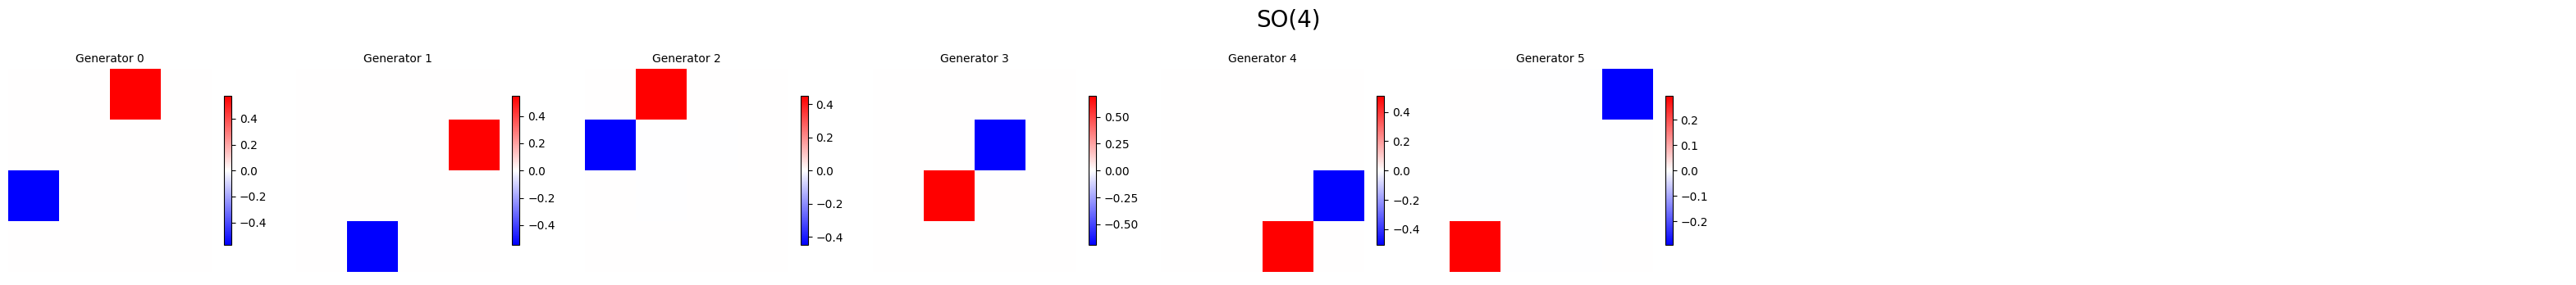

In [14]:
visualize_generators(model, filename="so4.png", group_name="SO(4)")

# SO(1,3) Lorentz Symmetry

In [15]:
#Manifold for SO(1,3)
import torch

def get_metric(n, device='cpu'):

    M = torch.eye(n, device=device)
    if n > 0: # Handle n=0 case if necessary, though SO(1,0) is trivial
        M[0, 0] = -1.0 # For Lorentz group SO(1, n-1)
    return M

In [16]:
M = get_metric(4, device="cuda:0") # Pass the device to get_metric
M

tensor([[-1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.]], device='cuda:0')

In [17]:
model1 = train_generic_lie_group(n=4,epochs=15, M=M)

  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 0 complete
Symmetry Closure Loss  8.516054153442383
Symmetry Orthogonality Loss  0.9725996255874634


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 1 complete
Symmetry Closure Loss  3.074795722961426
Symmetry Orthogonality Loss  1.0535778999328613


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 2 complete
Symmetry Closure Loss  1.4466502666473389
Symmetry Orthogonality Loss  1.0593773126602173


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 3 complete
Symmetry Closure Loss  0.641010582447052
Symmetry Orthogonality Loss  0.9580863118171692


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 4 complete
Symmetry Closure Loss  0.23490534722805023
Symmetry Orthogonality Loss  0.8085386157035828


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 5 complete
Symmetry Closure Loss  0.03677480295300484
Symmetry Orthogonality Loss  0.647822380065918


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 6 complete
Symmetry Closure Loss  0.008094019256532192
Symmetry Orthogonality Loss  0.2562769055366516


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 7 complete
Symmetry Closure Loss  0.0011372226290404797
Symmetry Orthogonality Loss  0.05251546576619148


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 8 complete
Symmetry Closure Loss  0.00023517229419667274
Symmetry Orthogonality Loss  0.007255319971591234


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 9 complete
Symmetry Closure Loss  1.5421359421452507e-05
Symmetry Orthogonality Loss  0.0005296184099279344


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 10 complete
Symmetry Closure Loss  3.911778492238227e-07
Symmetry Orthogonality Loss  9.65593153523514e-06


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 11 complete
Symmetry Closure Loss  2.8429522624939807e-10
Symmetry Orthogonality Loss  1.4746576404434109e-08


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 12 complete
Symmetry Closure Loss  7.395752846944825e-13
Symmetry Orthogonality Loss  3.3480382637292305e-13


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 13 complete
Symmetry Closure Loss  1.0532552477751644e-12
Symmetry Orthogonality Loss  7.008220162508204e-15


  0%|          | 0/977 [00:00<?, ?it/s]

EPOCH 14 complete
Symmetry Closure Loss  9.184762325697982e-13
Symmetry Orthogonality Loss  1.1681992111395138e-14


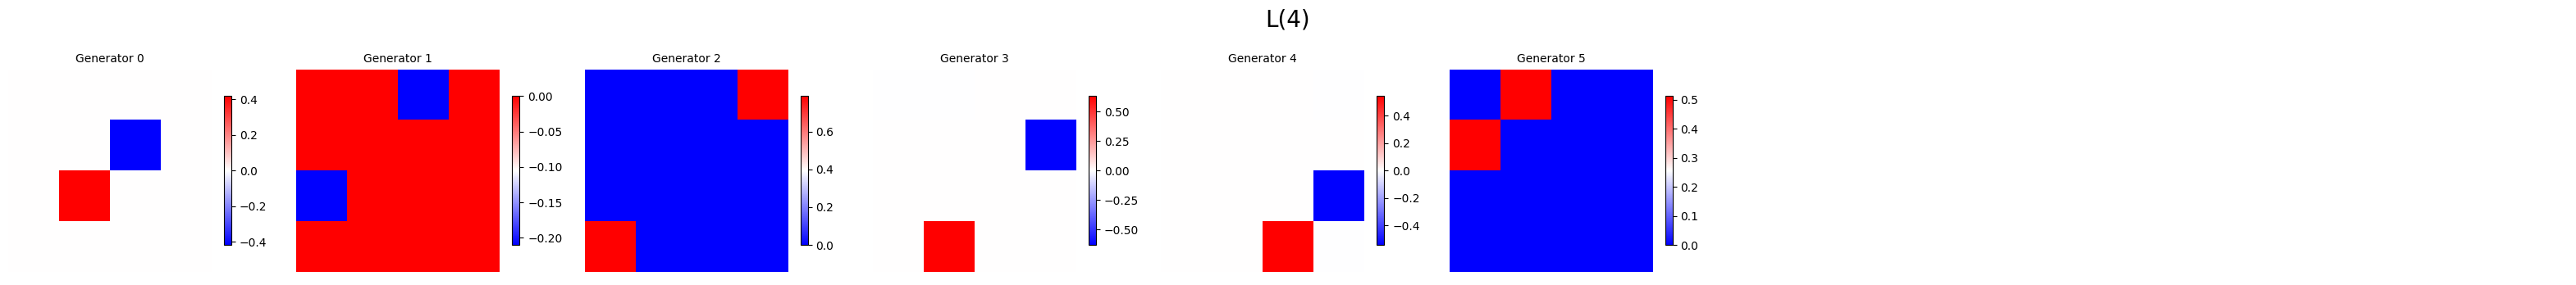

In [18]:
visualize_generators(model1, filename="Lorentz4.png", group_name="L(4)")